In [5]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt

import sys
from pathlib import Path

repo_parent = Path.cwd().resolve().parents[0]
if str(repo_parent) not in sys.path:
    sys.path.insert(0, str(repo_parent))

# 3) Autoreload to pick up edits to Maurice2/*
%load_ext autoreload
%autoreload 2

from main.dynamics import Dynamics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
xhat0 = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]) # Initial state estimate
sampling_rate = 20.0  # Hz
dt = 1.0 / sampling_rate

dynamics = Dynamics(dt=dt, x0=xhat0)
dynamics.setRocketParams(
    I_0=0.327,
    I_f=0.287,
    I_3=0.0035,
    x_CG_0=0.675,
    x_CG_f=0.635,
    m_0=2.944,
    m_f=2.589,
    m_p=0.355,
    d=0.0787,
    L_ne=1.17,
    Cnalpha_rocket=0.207,
    t_motor_burnout=1.971,
    t_launch_rail_clearance=0.308
)
dynamics.setFinParams(
    N=4,
    Cr=0.18,
    Ct=0.0597,
    s=0.0876,
    Cnalpha_fin=2.72025,
    delta=0.0
)
dynamics.setup_eom()
dynamics.forward_euler(xhat=xhat0)

t: 0.000, xhat: [0 0 0 0 0 0 1 0 0 0]
t: 0.050, xhat: [ 0.      0.      0.      0.      0.     -0.4905  1.      0.      0.
  0.    ]
t: 0.050, xhat: [ 0.      0.      0.      0.      0.     -0.4905  1.      0.      0.
  0.    ]
t: 0.100, xhat: [0.         0.         0.         0.         0.         4.10108366
 1.         0.         0.         0.        ]
t: 0.150, xhat: [0.         0.         0.         0.         0.         8.94803796
 1.         0.         0.         0.        ]
t: 0.200, xhat: [ 0.          0.          0.          0.          0.         13.99675026
  1.          0.          0.          0.        ]
t: 0.250, xhat: [ 0.          0.          0.          0.          0.         19.12782126
  1.          0.          0.          0.        ]
t: 0.300, xhat: [ 0.         0.         0.         0.         0.        24.2029018
  1.         0.         0.         0.       ]
t: 0.350, xhat: [ 0.          0.          0.          0.          0.         29.17528024
  1.          0.  

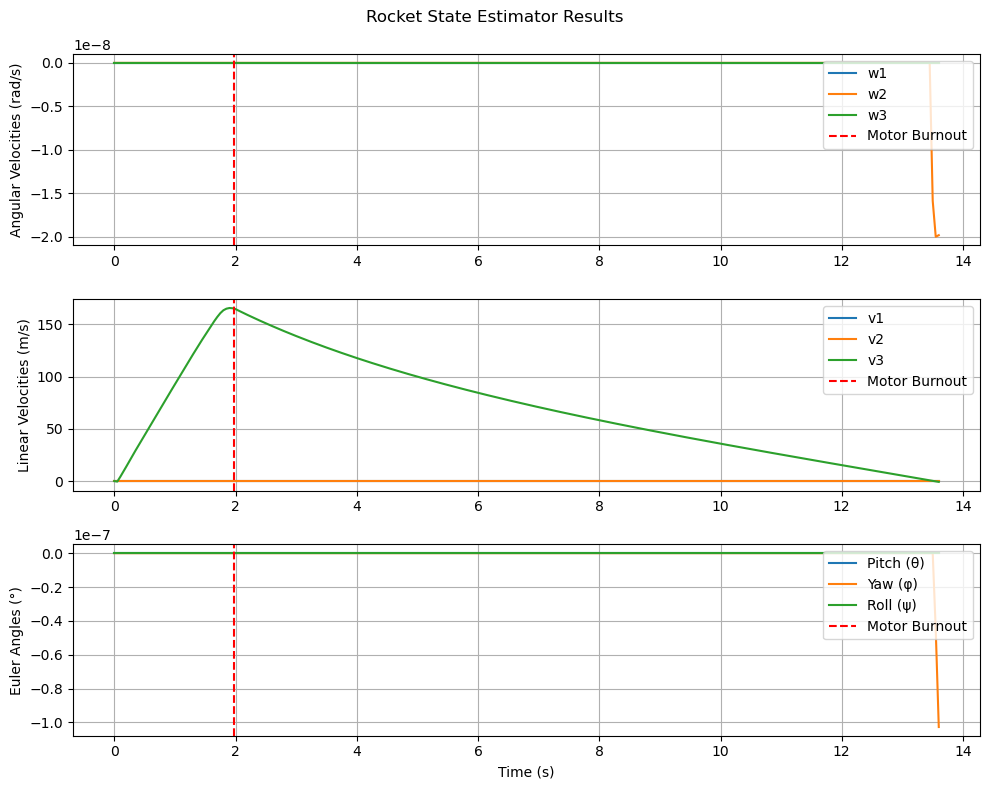

In [7]:
xhat = np.array(dynamics.states)
t = np.arange(0, xhat.shape[0]*dynamics.dt, dynamics.dt)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
fig.suptitle('Rocket State Estimator Results')
axs[0].plot(t, xhat[:, 0], label='w1')
axs[0].plot(t, xhat[:, 1], label='w2')
axs[0].plot(t, xhat[:, 2], label='w3')
axs[0].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[0].set_ylabel('Angular Velocities (rad/s)')
axs[0].legend(loc='upper right')
axs[0].grid()
axs[1].plot(t, xhat[:, 3], label='v1')
axs[1].plot(t, xhat[:, 4], label='v2')
axs[1].plot(t, xhat[:, 5], label='v3')
axs[1].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[1].set_ylabel('Linear Velocities (m/s)')
axs[1].legend(loc='upper right')
axs[1].grid()

# Convert quaternion to Euler angles for plotting
euler_angles = np.array([dynamics.quat_to_euler_xyz(q) for q in xhat[:, 6:10]])
axs[2].plot(t, np.rad2deg(euler_angles[:, 0]), label='Pitch (θ)')
axs[2].plot(t, np.rad2deg(euler_angles[:, 1]), label='Yaw (φ)')
axs[2].plot(t, np.rad2deg(euler_angles[:, 2]), label='Roll (ψ)')
axs[2].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[2].set_ylabel('Euler Angles (°)')
axs[2].set_xlabel('Time (s)')
axs[2].legend(loc='upper right')
axs[2].grid()
plt.tight_layout()

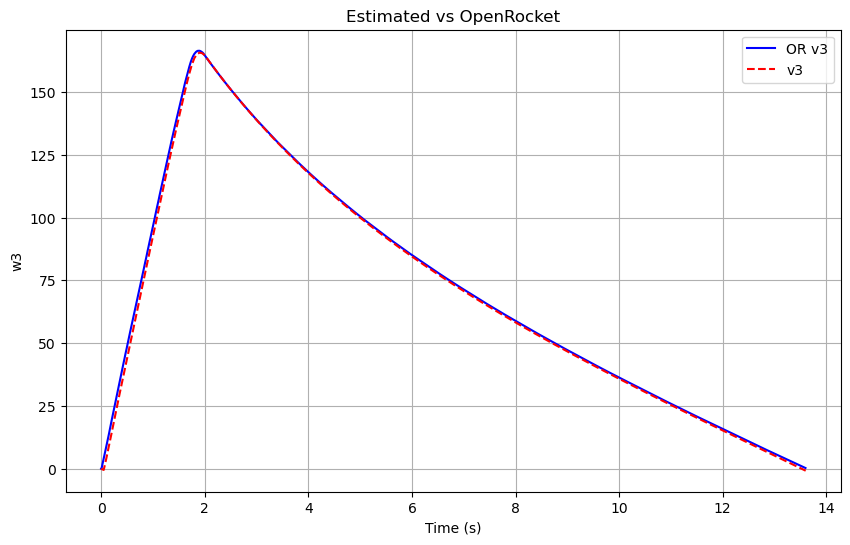

In [8]:
# Compare with OpenRocket data
import pandas as pd
openrocket_data = pd.read_csv("/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Courses/25-26/Fall 2025/AE 370/370 Projects/370 Project 1/ae370-project1/data/openrocket_data2.csv")
time = openrocket_data['# Time (s)']
mask = time <= t[-1]
v3_or = openrocket_data['Vertical velocity (m/s)'][mask]
w3_or = openrocket_data['Roll rate (°/s)'][mask]
v3_dyn = xhat[:, 5]
w3_dyn = xhat[:, 2]
plt.figure(figsize=(10, 6))
# plt.plot(time[mask], np.deg2rad(w3_or), label='OR w3', color='blue')
# plt.plot(t, w3_dyn, label='w3', color='red', linestyle='--')
plt.plot(time[mask], v3_or, label='OR v3', color='blue')
plt.plot(t, v3_dyn, label='v3', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('w3')
plt.title('Estimated vs OpenRocket')
plt.legend()
plt.grid()
plt.show()